# 1度のスイッチでボードをクリア
*Dr. リョウコのいる部屋の床は３ｘ３のタイルでできている。ひとつのタイルはひとつの量子ビットに対応している。<br/>
エネルギーの低い基底状態のタイルは平らだが、エネルギーレベルの高い励起状態の量子ビットは柱のようにそびえ立ち行く手を阻む。<br/> 
しかも2つの状態間を行き来する量子ビットがいくつか存在している。更に観察をつづけると、各量子ビットが取り得る状態の組み合わせが、<br/>
全部で４パターンしかないことに気づく。だが、スイッチは1度しか押せない。これは4枚のライツアウト問題を1度のスイッチ操作で解くのと同じだ。<br/>
１度のスイッチ操作でクリアできるボードをみつけて、Dr.リョウコが無事に部屋を通過できるのを助けよう。*

# Week2-B: 4-ライツアウト
この問題では、複数のバイナリデータを同時に取り扱います。
与えられた4枚のライツアウトボードのそれぞれが制約条件下で解けるかどうか、一つの量子回路で同時に判断できるよう工夫してみましょう。

例として、以下の4ボードの中から"１度のスイッチ操作でクリアできるボード"を発見する方法を考えてみましょう。
4ボードの初期状態は以下の２次元配列で与えられ、０と1がそれぞれ消灯と点灯を示しています。 
lightsout4_ex=\[\[Board 0\],\[Board 1\],\[Board 2\],\[Board 3\]\]

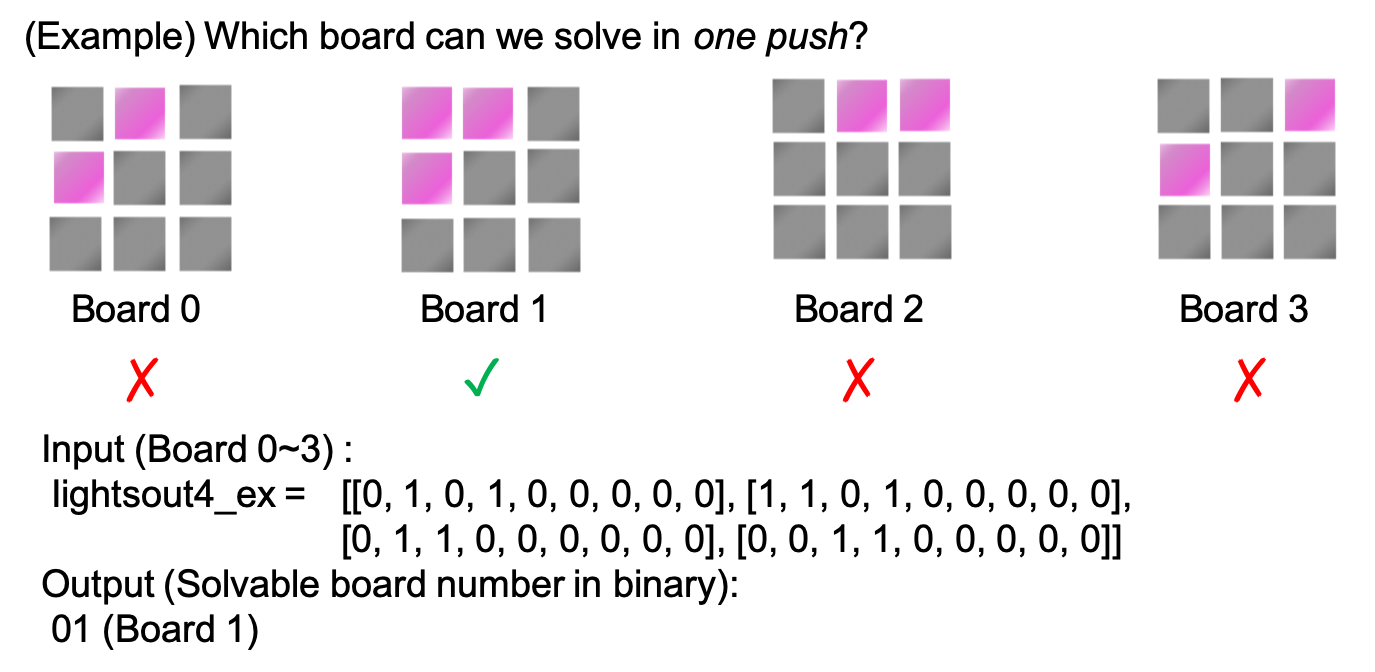

In [1]:
from IPython.display import Image, display
Image('4lightsout_ex.png')

## 解答戦略
ボードが一つなら、この例題は決定問題となります。
- 2-a問題のアルゴリズムを使って、出力に含まれる"１"を数え上げることで解決できるでしょう。
 
ボードが複数の場合、いくつかのアプローチが考えられます。 
1. 各ボードに対して、１ボード用のアルゴリズムを繰り返し適用する。
2. 複数のボード情報を同時に保持し、一度のアルゴリズム実行で解決する。
- 以下のコンテンツでは、後者のアプローチに挑戦します。

ここで、全てのボード情報をQubit上に保持するにはどうすれば良いでしょうか？  
1. ナイーブなデータ構造:　　9 Qubits/board * 4 boards > 32 qubits (ibm_qasm_simulatorの上限)。
2. 重ね合わせ状態を準備する:   $\vert Board 0\rangle + \vert Board 1\rangle + \vert Board 2\rangle + \vert Board 3\rangle$.
    - 状態生成に用いる回路構成は非自明。
3. 一つの解法として*qRAM*が知られている。
    - **長所**: 直感的な実装が可能。 
    - **短所**: 計算量が大きい。

もちろん他のより優れた方法を採用しても構いません。

ここでは*qRAM*に焦点を当て、その構成と実装について説明します。

In [7]:
from qiskit import *
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit import IBMQ, Aer, execute
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2020-10-15 16:54:13,953: Credentials are already in use. The existing account in the session will be replaced.


## qRAM: Quantum Random Access Memory

古典的なコンピュータでは、RAM(Random Access Memory)は揮発性メモリの一種で、メモリアドレス $j$ を持ち、各アドレス $D_j$ に対応するバイナリデータを格納しています。

量子コンピュータの[qRAM](https://arxiv.org/abs/0708.1879)の場合、アドレスQubits $a$ は、$N$ 個のアドレスを重ね合わせ状態で持ち、対応するバイナリデータを状態ベクトルとしてデータQubit $d$ に格納しています。
\\[
\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert 0 \rangle_{d}\xrightarrow{qRAM}\sum_{j}\frac{1}{\sqrt{N}}\vert j \rangle_{a}\vert D_{j} \rangle_{d}
\\]　　

右辺の状態を"qRAM"、対応するゲート操作を"qRAM演算"と呼ぶことにします。

qRAM演算には $\mathcal{O}(N\log N)$ 個のゲートが必要ですが、直感的にバイナリデータの重ね合わせ状態を作ることができます。
qRAMは、HHLアルゴリズムをはじめとする量子機械学習の様々なアルゴリズムに応用されています。 
今回は、GroverのアルゴリズムにqRAMを適用してみましょう。

## 例題: データをqRAMから見つけよう
$k_0, k_1, ... , k_{n-1}$ がこの順に格納された $n$ アドレスの qRAM を用意します。
Groverのアルゴリズムを使って，$m$という数字が格納されているアドレスを求めます。
- $n = 4$
- $k = [1,2,5,7]$
- $m = 7$

### qRAM演算
以下にqRAM演算の実装例を示します。

In [ ]:
address = QuantumRegister(2)
data = QuantumRegister(3)
c = ClassicalRegister(5)
qc = QuantumCircuit(address,data,c)

# address preparation
qc.h([address[0],address[1]])
qc.barrier()
# address 0 -> data = 1
qc.x([address[0],address[1]])
qc.ccx(address[0],address[1],data[2])
qc.x([address[0],address[1]])
qc.barrier()
# address 1 -> data = 2
qc.x(address[0])
qc.ccx(address[0],address[1],data[1])
qc.x(address[0])
qc.barrier()
# address 2 -> data = 5
qc.x(address[1])
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[0])
qc.x(address[1])
qc.barrier()
# address 3 -> data = 7
qc.ccx(address[0],address[1],data[2])
qc.ccx(address[0],address[1],data[1])
qc.ccx(address[0],address[1],data[0])
qc.barrier()


#Check the qRAM　status
qc.measure(address[0:2], c[0:2])
qc.measure(data[0:3], c[2:5])
 
# Reverse the output string.
qc = qc.reverse_bits()

#backend = provider.get_backend('ibmq_qasm_simulator')
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend=backend, shots=8000, seed_simulator=12345, backend_options={"fusion_enable":True})
#job = execute(qc, backend=backend, shots=8192)
result = job.result()
count =result.get_counts()
print(count)

qc.draw(output='mpl')

### qRAM 内のデータ探索
Groverのアルゴリズムを実行するには、$m$を含む**アドレスQubit**の符号を反転させます。 
また、拡散変換の前に別のqRAM演算でデータ Qubitを初期化する必要があります。

\begin{align*}
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f}
\xrightarrow{oracle}  
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j} = m\\
\vert j \rangle_{a}\vert D_{j} \rangle_{d} \vert - \rangle_{f},  D_{j}  \neq m
 \end{array}
 \right.
 \xrightarrow{qRAM}
\left \{
 \begin{array}{l}
-\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},  D_{j} = m \\
\vert j \rangle_{a}\vert 0 \rangle_{d}\vert - \rangle_{f},　D_{j}\neq m
 \end{array}
 \right.
 \end{align*}
 
ここで、$f$ はフラグQubitを表します。
この例題の場合，[C3X gate](https://qiskit.org/documentation/stubs/qiskit.circuit.library.C3XGate.html#qiskit.circuit.library.C3XGate)でオラクル操作を実行することができます。

以下に[qRAMの例題](#qRAM-Example:-Find-the-data-from-qRAM)の回路全体を示しています。  

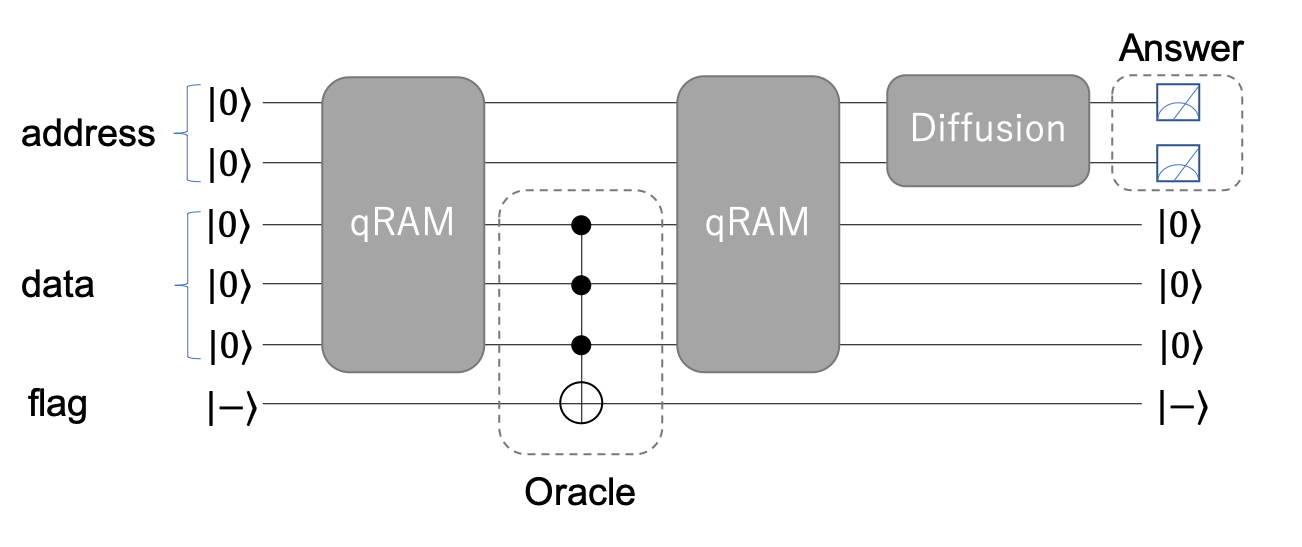

In [2]:
Image('circuit_ex.png')

### qRAMの実装についての考察
上記の説明では、ナイーブな*qRAM演算*回路を紹介しました。  
データ構造にもよりますが、ゲートの**合成**(等価変換)の技術を用いることで回路を簡略化することができます。
また、[RCCX](https://qiskit.org/documentation/stubs/qiskit.circuit.library.RCCXGate.html#qiskit.circuit.library.RCCXGate)などの簡略化されたゲートは、あなたの実装における*CNOT*の節約に役立つかもしれません。
以下にゲート合成の例を示します。

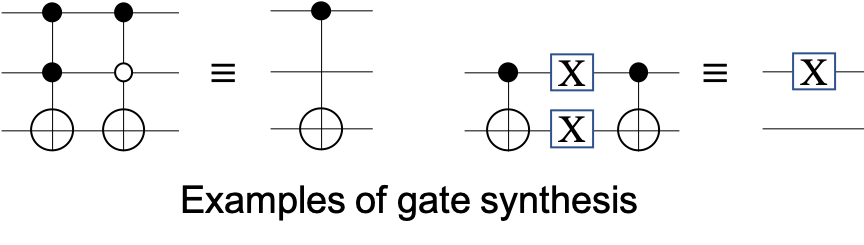

In [3]:
Image('gatesynthesis_ex.png')

## ラーニング演習 II-B
4-ライツアウトをqRAMを用いて解決してみましょう。

ボード状態が以下の lightsout4 = \[\[Board 0\], \[Board 1\], \[Board 2\], \[Board 3\]\] で与えられるとき、3回のスイッチ操作で解決できるボード番号を２進数形式で答える量子回路を作成してください。 (ex. Board 0 -> 00, 1->01, 2 -> 10, 3 -> 11) 

量子回路では、パズルの答えとなるsolution(2bit)のみを観測してください。

提出形式は、lightsout4 を引数とし、`QuantumCircuit`を返す関数です（関数名は任意のものを付けて問題ありません）。lightsout4に別のデータセットをインプットしても機能するようにしてください。

**尚、量子回路は 28 qubits 以内で実装してください。**

説明で用いられているものと同じエンディアンで解答が得られるようになっているか注意してください。以下の関数を使っても構いません。

```python
qc = qc.reverse_bits()
```

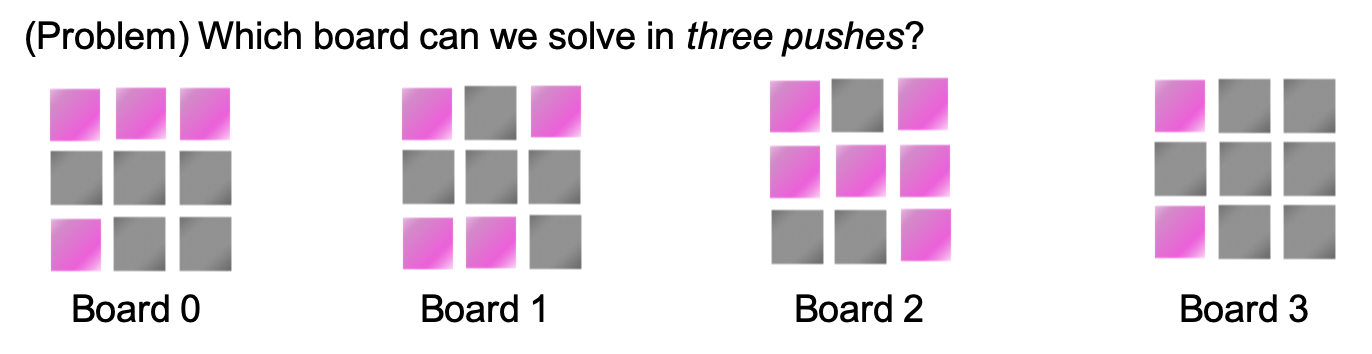

In [2]:
Image('4lightsout_pr.png')

In [3]:
lightsout4=[[1, 1, 1, 0, 0, 0, 1, 0, 0],[1, 0, 1, 0, 0, 0, 1, 1, 0],[1, 0, 1, 1, 1, 1, 0, 0, 1],[1, 0, 0, 0, 0, 0, 1, 0, 0]]

### ヒント
- [qRAM Data search](#qRAM-Data-search) のオラクルを適切なものに変更しましょう。
- *qRAM演算*におけるデータ書き込みは任意の順序で行うことができます。アドレスの _ハミング距離_ や入力されるデータを考慮することでゲート数を削減できるかもしれません。

In [ ]:
def week2b_ans_func(lightout4):
    ##### ここに量子回路を作成してください。
    ####  尚、異なる入力(lightout4)でも問題が解ける関数にしてください。異なる入力で検証を行います。
    
    return qc

In [ ]:
# 提出用コード
from qc_grader import prepare_ex2b, grade_ex2b, submit_ex2b

# 以下のprepare_ex2b()関数で回路を実行してください。
# prepare_ex2b()関数はQuantumCircuitのみを引数として、execute()関数のように働きます。
job  =  prepare_ex2b(week2b_ans_func)

result = job.result()
count = result.get_counts()
original_problem_set_counts = count[0]

original_problem_set_counts
# 最も観測回数が多いビット列が解として扱われます。

In [ ]:
# 以下のコードを実行して答えを確認してください。
# スコアとしてQuantumCircuitの量子コストが得られます。尚、量子コストは第3週の問題のみランクに影響します。
grade_ex2b(job)

In [ ]:
# 以下のコードを実行して提出してください。期間中は何度でも再提出できます。
submit_ex2b(job)